In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from datetime import datetime
import pandas as pd
import gc

np.random.seed(42)
tf.random.set_seed(42)
print(f"TensorFlow: {tf.__version__}, GPU: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow: 2.19.0, GPU: 1


In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
DATASET_NAME = 'datamunge/sign-language-mnist'
DOWNLOAD_PATH = './sign-language-mnist'
os.makedirs(DOWNLOAD_PATH, exist_ok=True)
!kaggle datasets download -d {DATASET_NAME} -p {DOWNLOAD_PATH} --unzip

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
  0% 0.00/62.6M [00:00<?, ?B/s]
100% 62.6M/62.6M [00:00<00:00, 1.39GB/s]


In [4]:
train_df = pd.read_csv(f'{DOWNLOAD_PATH}/sign_mnist_train.csv')
test_df = pd.read_csv(f'{DOWNLOAD_PATH}/sign_mnist_test.csv')

y_train = train_df['label'].values
y_test = test_df['label'].values
X_train = train_df.drop('label', axis=1).values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = test_df.drop('label', axis=1).values.reshape(-1, 28, 28, 1).astype('float32') / 255.0

del train_df, test_df
gc.collect()

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (27455, 28, 28, 1), Test: (7172, 28, 28, 1)


In [5]:
original_label_to_letter = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
}
unique_labels_sorted = sorted(np.unique(y_train))
class_names = [original_label_to_letter[label] for label in unique_labels_sorted]
num_classes = len(class_names)

unique_labels = np.unique(y_train)
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
y_train_remapped = np.array([label_mapping[label] for label in y_train])
y_test_remapped = np.array([label_mapping[label] for label in y_test])
y_train_cat = keras.utils.to_categorical(y_train_remapped, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_remapped, num_classes)

del y_train, y_test, y_train_remapped, y_test_remapped
gc.collect()

print(f"Classes: {num_classes}")

Classes: 24


In [6]:
CONFIG = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 32,
    'EPOCHS': 30,
    'INITIAL_LR': 1e-3,
    'FINE_TUNE_LR': 1e-5,
    'FINE_TUNE_EPOCHS': 15,
    'VALIDATION_SPLIT': 0.2,
    'NUM_CLASSES': num_classes,
    'SEED': 42,
    'PATIENCE': 5
}

os.makedirs('models', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

In [7]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']])
    image = tf.image.grayscale_to_rgb(image)
    return image, label

preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [8]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_cat, test_size=CONFIG['VALIDATION_SPLIT'],
    random_state=CONFIG['SEED'], stratify=np.argmax(y_train_cat, axis=1)
)

del X_train, y_train_cat
gc.collect()

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(CONFIG['BATCH_SIZE']).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(CONFIG['BATCH_SIZE']).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(CONFIG['BATCH_SIZE']).prefetch(AUTOTUNE)

del X_train_split, X_val_split, y_train_split, y_val_split
gc.collect()

print("Datasets ready")

Datasets ready


In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1)
], name='augmentation')

def prepare_dataset(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare_dataset(train_ds, augment=True)
val_ds = prepare_dataset(val_ds, augment=False)
test_ds = prepare_dataset(test_ds, augment=False)

In [10]:
inputs = layers.Input(shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, pooling='avg')
base_model.trainable = False

x = base_model.output
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs, name='ResNet50_ASL')

model.compile(
    optimizer=Adam(learning_rate=CONFIG['INITIAL_LR']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Parameters: {model.count_params():,}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Parameters: 24,126,616


In [11]:
checkpoint_path = f'models/resnet50_asl_{timestamp}.keras'

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=CONFIG['PATIENCE'], restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
]

In [12]:
history = model.fit(train_ds, validation_data=val_ds, epochs=CONFIG['EPOCHS'], callbacks=callbacks, verbose=2)
gc.collect()

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.59625, saving model to models/resnet50_asl_20260111_120000.keras
687/687 - 336s - 489ms/step - accuracy: 0.3026 - loss: 2.6496 - val_accuracy: 0.5962 - val_loss: 1.8125 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_accuracy improved from 0.59625 to 0.62848, saving model to models/resnet50_asl_20260111_120000.keras
687/687 - 302s - 439ms/step - accuracy: 0.3836 - loss: 2.1940 - val_accuracy: 0.6285 - val_loss: 1.5192 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy improved from 0.62848 to 0.65689, saving model to models/resnet50_asl_20260111_120000.keras
687/687 - 322s - 468ms/step - accuracy: 0.4135 - loss: 2.0991 - val_accuracy: 0.6569 - val_loss: 1.4459 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy improved from 0.65689 to 0.68603, saving model to models/resnet50_asl_20260111_120000.keras
687/687 - 307s - 446ms/step - accuracy: 0.4301 - loss: 2.0454 - val_accuracy: 0.6860 - val_loss: 1.3642

1249

In [13]:
base_model.trainable = True
for layer in base_model.layers[:140]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=CONFIG['FINE_TUNE_LR']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_ft = f'models/resnet50_asl_ft_{timestamp}.keras'
callbacks_ft = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8, verbose=1),
    ModelCheckpoint(filepath=checkpoint_ft, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
]

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=CONFIG['FINE_TUNE_EPOCHS'], callbacks=callbacks_ft, verbose=2)
gc.collect()

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.43180, saving model to models/resnet50_asl_ft_20260111_120000.keras
687/687 - 341s - 496ms/step - accuracy: 0.4319 - loss: 2.5272 - val_accuracy: 0.4318 - val_loss: 2.4795 - learning_rate: 1.0000e-05
Epoch 2/15

Epoch 2: val_accuracy improved from 0.43180 to 0.58241, saving model to models/resnet50_asl_ft_20260111_120000.keras
687/687 - 313s - 456ms/step - accuracy: 0.5602 - loss: 1.5940 - val_accuracy: 0.5824 - val_loss: 1.5831 - learning_rate: 1.0000e-05
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.58241
687/687 - 304s - 443ms/step - accuracy: 0.6117 - loss: 1.4243 - val_accuracy: 0.4578 - val_loss: 2.5427 - learning_rate: 1.0000e-05
Epoch 4/15

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 4: val_accuracy did not improve from 0.58241
687/687 - 324s - 472ms/step - accuracy: 0.6353 - loss: 1.3317 - val_accuracy: 0.5309 - val_loss: 1.9122 - learning_rate: 1.0000e-05
Epoch 5/15

Ep

815

In [14]:
test_results = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")

Test Loss: 0.6376, Test Accuracy: 0.8620


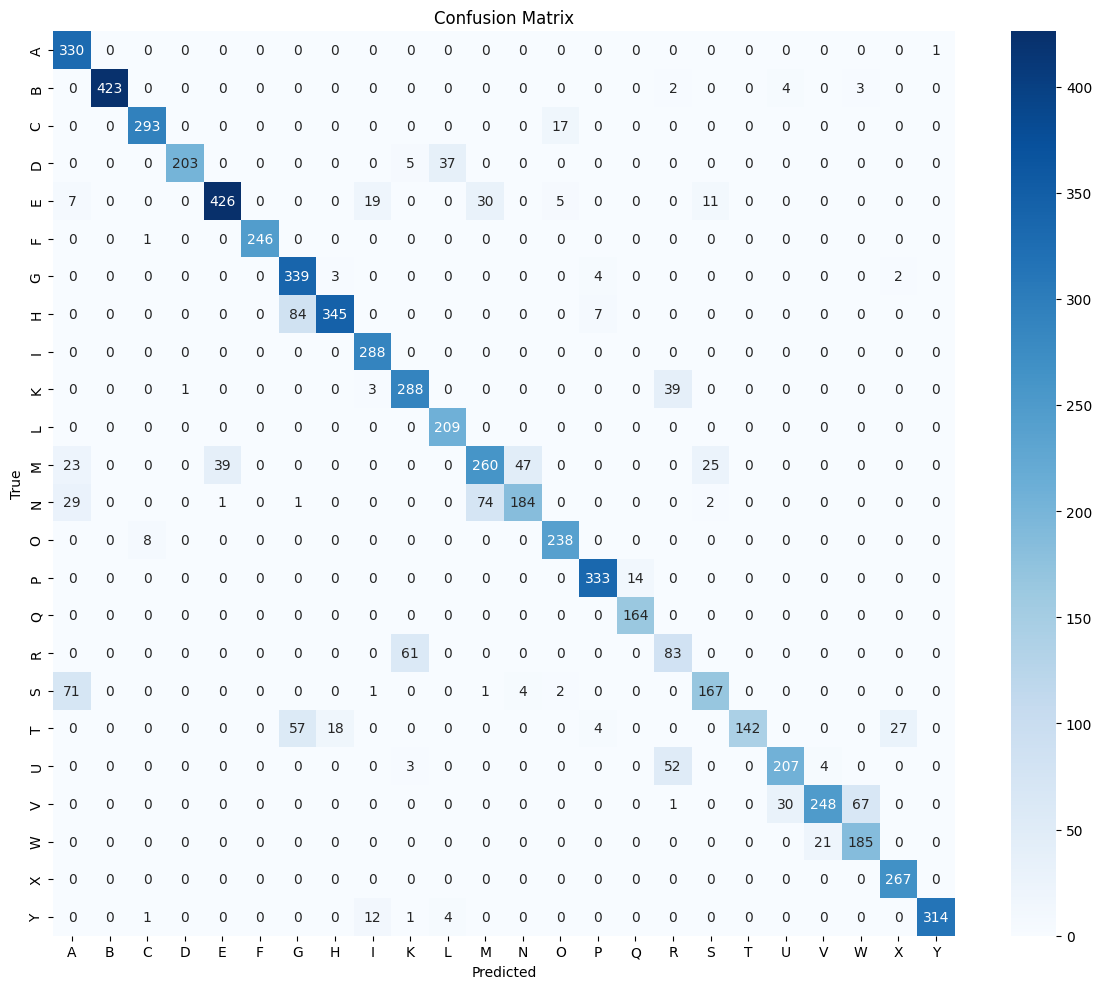

              precision    recall  f1-score   support

           A      0.717     0.997     0.834       331
           B      1.000     0.979     0.989       432
           C      0.967     0.945     0.956       310
           D      0.995     0.829     0.904       245
           E      0.914     0.855     0.884       498
           F      1.000     0.996     0.998       247
           G      0.705     0.974     0.818       348
           H      0.943     0.791     0.860       436
           I      0.892     1.000     0.943       288
           K      0.804     0.870     0.836       331
           L      0.836     1.000     0.911       209
           M      0.712     0.660     0.685       394
           N      0.783     0.632     0.700       291
           O      0.908     0.967     0.937       246
           P      0.957     0.960     0.958       347
           Q      0.921     1.000     0.959       164
           R      0.469     0.576     0.517       144
           S      0.815    

In [15]:
y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

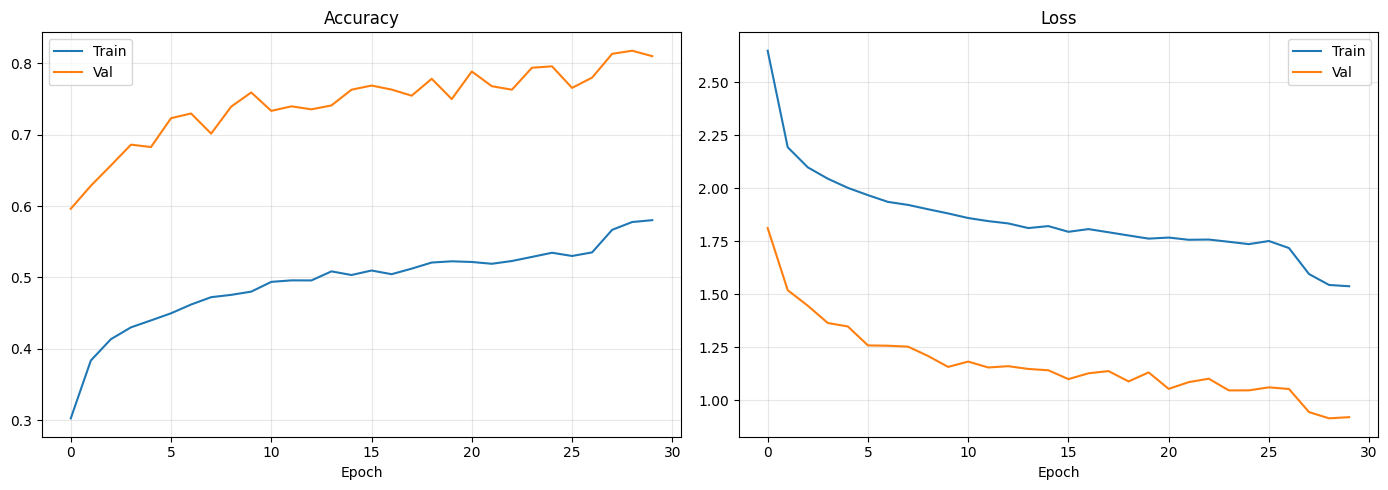

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
model.save(f'models/resnet50_asl_final_{timestamp}.keras')
print(f"Model saved: models/resnet50_asl_final_{timestamp}.keras")

Model saved: models/resnet50_asl_final_20260111_120000.keras
